### Utilizes Train Test Split, KFold CV=5, shuffle=True, and RandomSearch

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from tqdm import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt


# Load the data
imputed_data = pd.read_csv("sbux_clv_drop_AOV_and_completed_offers_across_channels_with_dummies.csv")

# Prepare the data
# After calling get dummies in the preprocessing phase,
# Drop Gender_Unknown, Age_Unknown, HH Income_Unknown to reduce multicollinearity
# Prepare the data
X = imputed_data[['MemberSince',
                  'Recency (# Days ago from last trans. As of final day up to Day 15)',
                  'Frequency (# Trans. from Day 1-15)',
                  'Monetary Value (Sum of Trans. from Day 1-15)',
                  '# of Marketing offers that Starbucks sent to each customer from Day 1-15',
                  '# of Marketing offers that were viewed from Day 1-15',
                  '# of Marketing offers that were successfully completed from Day 1-15',
                  'Marketing Offer View Rate from Day 1-15',
                  'Marketing Offer Response Rate from Day 1-15',
                  'Age_18-34', 'Age_35-50', 'Age_51-67',
                  'Age_68-84', 'Age_85-101', 'Gender_F', 'Gender_M',  # 'Age_Unknown',
                  'Gender_O', 'HH Income_100k-120k',  # 'Gender_Unknown','HH Income_Unknown'
                  'HH Income_30k-50k', 'HH Income_50k-75k', 'HH Income_75k-100k']]

y = imputed_data['Sum(Trans. Amt from Day 16-30)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, -1],
    'num_leaves': [31, 63, 127],
}

# Perform hyperparameter tuning using randomized search and cross-validation
model = LGBMRegressor()
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=KFold(n_splits=5, shuffle=True),
                                   scoring='neg_mean_absolute_error')
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

LGBMRegressor(max_depth=3)

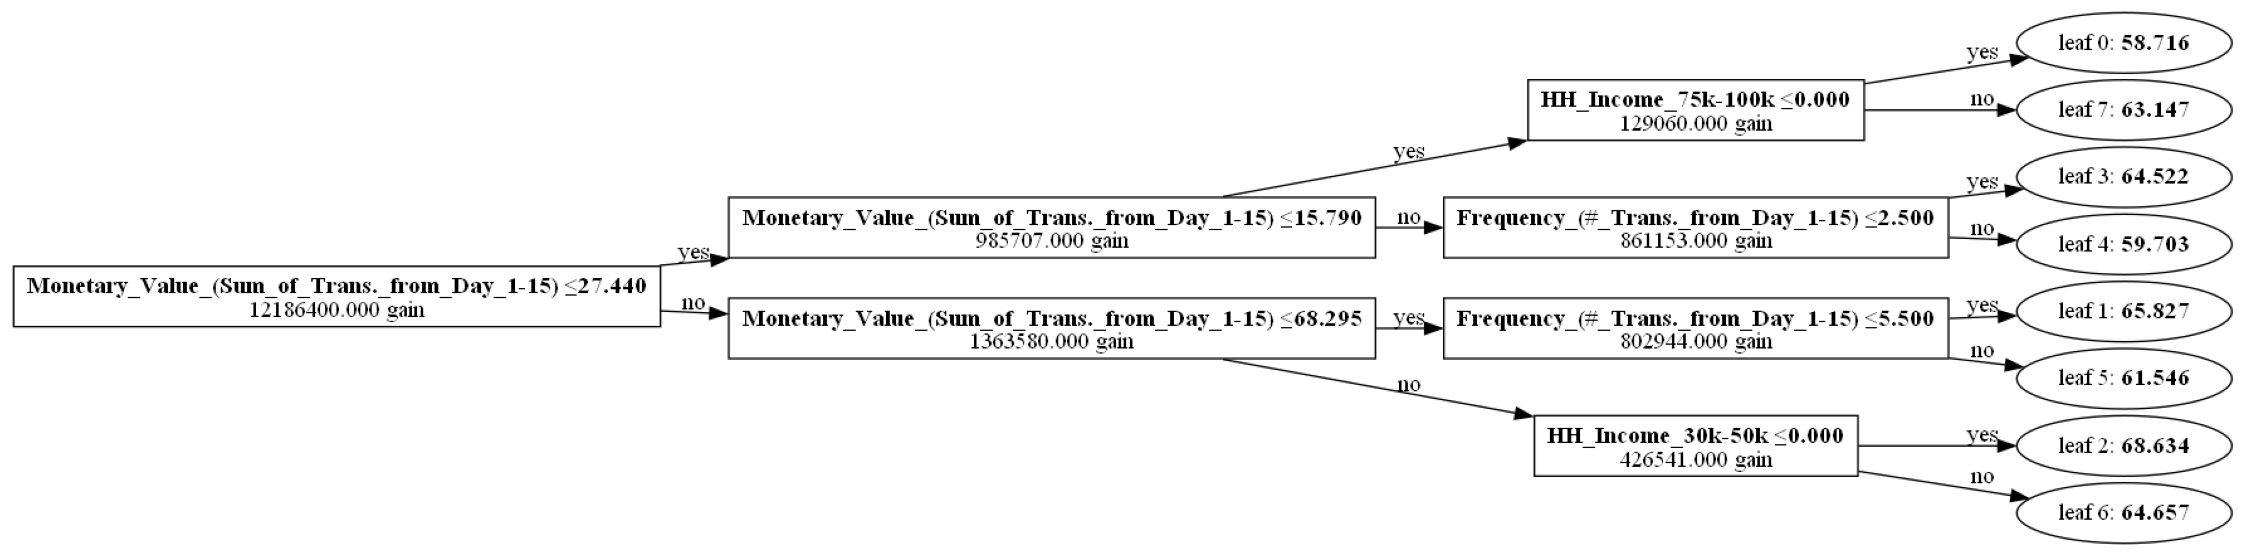

In [2]:
# Visualize the tree structure of the best model with higher DPI for clarity
lgb.plot_tree(best_model, figsize=(40, 40), show_info=['split_gain'], precision=3)
plt.savefig("tree_visualization.png", dpi=300)
plt.show()

In [3]:
# Calculate quantiles
quantiles = [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]

# Calculate actual and predicted CLV quantiles on the test set
actual_clv_quantiles = np.quantile(y_test, quantiles)
predicted_clv_quantiles = np.quantile(best_model.predict(X_test), quantiles)

# Calculate evaluation metrics for each quantile
mae = []
mape = []

# Add tqdm progress bar
with tqdm(total=len(quantiles), desc="Calculating Metrics") as pbar:
    for i in range(len(quantiles)):
        # Select the data points within the quantile range
        if i == len(quantiles) - 1:
            quantile_mask = (y_test >= actual_clv_quantiles[i])
        else:
            quantile_mask = (y_test >= actual_clv_quantiles[i]) & (y_test <= actual_clv_quantiles[i + 1])
        quantile_X = X_test[quantile_mask]
        quantile_y = y_test[quantile_mask]

        # Calculate evaluation metrics for the quantile
        mae.append(mean_absolute_error(quantile_y, best_model.predict(quantile_X)))
        mape.append(np.mean(np.abs((quantile_y - best_model.predict(quantile_X)) / quantile_y)) * 100)
        
        # Update the tqdm progress bar
        pbar.update(1)

# Create a DataFrame with the results
results = pd.DataFrame({
    'Quantile': ['Bottom 20%', '20-40%', '40-60%', '60-80%', '80-90%', '90-95%', '95-99%'],
    'Avg. Actual CLV': actual_clv_quantiles.round(2),
    'Avg. Predicted CLV': predicted_clv_quantiles.round(2),
    'MAE': mae,
    'MAPE': mape
})

# Format the columns
results['Avg. Actual CLV'] = '$' + results['Avg. Actual CLV'].astype(str)
results['Avg. Predicted CLV'] = '$' + results['Avg. Predicted CLV'].astype(str)
results['MAE'] = results['MAE'].round(2)
results['MAPE'] = results['MAPE'].round(1).astype(str) + '%'

print("Best Model Parameters:")
print(best_params)

# Display the results DataFrame
results


Calculating Metrics: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 49.39it/s]

Best Model Parameters:
{'num_leaves': 31, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


,Quantile,Avg. Actual CLV,Avg. Predicted CLV,MAE,MAPE
0,Bottom 20%,$10.81,$18.01,22.83,129.8%
1,20-40%,$26.0,$40.38,33.33,87.4%
2,40-60%,$54.95,$82.1,26.57,37.2%
3,60-80%,$99.23,$107.49,24.76,21.2%
4,80-90%,$135.07,$117.79,46.28,30.5%
5,90-95%,$169.55,$126.67,109.94,47.7%
6,95-99%,$435.8,$144.45,631.54,85.7%
